In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import json
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from os.path import join
import os
import copy
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn import linear_model

In [2]:
check_previous = 3

def getAnamoly(ypoints):

    for i in range(check_previous-1,len(ypoints)):
        
        flag=0
        if ypoints[i]==1:
            for prev in range(check_previous+1,-1,-1):
                if ypoints[i-prev] >= 1:
                    flag+=1
                else: 
                    flag=0
            if flag >= check_previous-1:
                ypoints[i] = 2 
                
    return ypoints

In [3]:
cuttoff =100

In [4]:
Bug_id = "531755"
attribute = "EC"

under_sampled_days = [x for x in range(1,36)] + [x for x in range(101,127)]


number_of_modules = 331
num_modules = number_of_modules 
root_path="./MDAP_processed/"
fm_path="./dataset/toy_train/FM/531755/EC"

bug_Ids=[Bug_id] 
parameters={'alpha':[0.001,0.1,1,20,50,100,10^6]}
ridge=Ridge(normalize=False)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)


ridge_regressor=GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=cv)

#make directory for WM
try:
    os.mkdir(join(root_path,"WM"))
except OSError as err:
    print(err)
wm_path=join(root_path,"WM")
WM_NAME = "WM"
print(wm_path)

[Errno 17] File exists: './MDAP_processed/WM'
./MDAP_processed/WM


In [6]:
for bug in bug_Ids:
    #create wM folder
    try:
        os.mkdir(join(wm_path, bug))
    except OSError as error:
        print(error)
    op_bug_path=join(wm_path, bug)
    in_bug_path=fm_path
    
    for feature in ["EC"]:
        try:
            os.mkdir(join(op_bug_path, feature))
        except OSError as err:
            print(err)
        op_feature_path=join(op_bug_path, feature)
        in_feature_path=in_bug_path

        num_days=len(os.listdir(in_feature_path))
        print("number of days={}".format(num_days))
        score_mse_lst=[]
        mse=0
        mse_module_lst=[0]*number_of_modules# no. of modules
        for day in os.listdir(in_feature_path):
            print("day={}".format(day))
            
            FM_df=pd.read_csv(join(in_feature_path, day))            
            modulo_names=FM_df.columns
            FM=FM_df.to_numpy()
           
            print("length of FM={}".format(len(FM)))
           
            num_modules=len(FM[0])#should be 331
            print("number of modules={}".format(num_modules))
            num_cases=len(FM)#case means system Id
            WM=[]# number of modules * number of modules-1 = 4*3
            for target_module in range(num_modules):
                Xs=np.delete(FM,target_module,1) 
                Y=FM[:,target_module]
                print("shape of Xs={}\nshape of Y={}".format(np.shape(Xs),np.shape(Y)))
                ridge_regressor.fit(Xs,Y)
                best_ridge=ridge_regressor.best_estimator_
                Weight_vector_for_target_module=np.array(best_ridge.coef_)
                print("shape of Weight Vector_for_target_module={}".format(np.shape(Weight_vector_for_target_module)))
                WM.append(Weight_vector_for_target_module)
                score_mse_lst.append({"day":day, "target_module":target_module, "score":ridge_regressor.best_params_, "mse":ridge_regressor.best_score_})
                mse+=ridge_regressor.best_score_
                mse_module_lst[target_module]+=ridge_regressor.best_score_
            print("shape of WM={}".format(np.shape(WM)))
            if (feature=="EC"):
                df=pd.DataFrame(WM)
                df.to_csv(join(op_feature_path,day))



[Errno 17] File exists: './MDAP_processed/WM/531755'
[Errno 17] File exists: './MDAP_processed/WM/531755/EC'
number of days=126
day=day 13.csv
length of FM=70
number of modules=331
shape of Xs=(70, 330)
shape of Y=(70,)
shape of Weight Vector_for_target_module=(330,)
shape of Xs=(70, 330)
shape of Y=(70,)
shape of Weight Vector_for_target_module=(330,)
shape of Xs=(70, 330)
shape of Y=(70,)
shape of Weight Vector_for_target_module=(330,)
shape of Xs=(70, 330)
shape of Y=(70,)
shape of Weight Vector_for_target_module=(330,)
shape of Xs=(70, 330)
shape of Y=(70,)
shape of Weight Vector_for_target_module=(330,)
shape of Xs=(70, 330)
shape of Y=(70,)
shape of Weight Vector_for_target_module=(330,)
shape of Xs=(70, 330)
shape of Y=(70,)
shape of Weight Vector_for_target_module=(330,)
shape of Xs=(70, 330)
shape of Y=(70,)
shape of Weight Vector_for_target_module=(330,)
shape of Xs=(70, 330)
shape of Y=(70,)
shape of Weight Vector_for_target_module=(330,)
shape of Xs=(70, 330)
shape of Y=(70

In [8]:
print(fm_path)
print(op_feature_path)

./dataset/toy_train/FM/531755/EC
./MDAP_processed/WM/531755/EC


In [15]:
Main_dictionary ={}
cases_pred_case_i={}
cases_pred_error_case_i={}

start_time=time.time()
module_predictions_tuples_case_specific = {}

fm_path_test = "./dataset/toy_test/FM/531755/EC"

FM_data = pd.read_csv('{}/day {}.csv'.format(fm_path_test,1))
number_of_cases = len(FM_data)
for i in range(number_of_cases):
    cases_pred_case_i[i]=[]
    cases_pred_error_case_i[i]=[]

for i in range(number_of_modules):
    module_predictions_tuples_case_specific[i] = []

for day_c in range(1,127): 
        FM_data = pd.read_csv('{}/day {}.csv'.format(fm_path_test,day_c))

        Main_dictionary ={}
        for i in range(number_of_modules):
            Main_dictionary[i] = np.full((number_of_cases,126), 999)  #np.zeros(shape=(70,126))  
        for WM_i in range(1,127):
            if day_c!=WM_i:
                WM_data = pd.read_csv('{}/day {}.csv'.format(op_feature_path,WM_i), index_col=0)

                for module_i in range(number_of_modules):
                    true_values = FM_data.iloc[:,module_i].to_numpy()[np.newaxis]
                    true_values = true_values.T

                    cases_data = FM_data.drop(FM_data.columns[[module_i]], axis = 1)

                    weights = WM_data.iloc[module_i].to_numpy()[np.newaxis] 
                    weights = weights.T

                    predicted_values = np.dot(cases_data,weights)

                    error_values = true_values - predicted_values
                    error_values = abs(error_values)
                    error_vector = np.array(error_values,ndmin=0)
                    error_vector = np.reshape(error_vector, (number_of_cases,))
                    
                    Main_dictionary[module_i][:,WM_i-1] =  error_vector
    
    
        for case_i in range(number_of_cases):
            cases_pred = []
            error_with_wm=[]
            for wm_i in range(1,127):
                error=0


                for module_i in range(number_of_modules):
                    error += Main_dictionary[module_i][case_i][wm_i-1]

                error = error/number_of_modules
                if wm_i not in under_sampled_days: 
                    error = 9999
                error_with_wm.append(error)

            min_error = min(error_with_wm)
            min_error_index = error_with_wm.index(min_error)
            cases_pred_error_case_i[case_i].append(min_error)
            if min_error_index<100:
                cases_pred_case_i[case_i].append(0)
            else:
                cases_pred_case_i[case_i].append(1)

        print("day done {}".format(day_c))


            
print("execution time={}".format(time.time()-start_time))

day done 1
day done 2
day done 3
day done 4
day done 5
day done 6
day done 7
day done 8
day done 9
day done 10
day done 11
day done 12
day done 13
day done 14
day done 15
day done 16
day done 17
day done 18
day done 19
day done 20
day done 21
day done 22
day done 23
day done 24
day done 25
day done 26
day done 27
day done 28
day done 29
day done 30
day done 31
day done 32
day done 33
day done 34
day done 35
day done 36
day done 37
day done 38
day done 39
day done 40
day done 41
day done 42
day done 43
day done 44
day done 45
day done 46
day done 47
day done 48
day done 49
day done 50
day done 51
day done 52
day done 53
day done 54
day done 55
day done 56
day done 57
day done 58
day done 59
day done 60
day done 61
day done 62
day done 63
day done 64
day done 65
day done 66
day done 67
day done 68
day done 69
day done 70
day done 71
day done 72
day done 73
day done 74
day done 75
day done 76
day done 77
day done 78
day done 79
day done 80
day done 81
day done 82
day done 83
day done 84
d

Case =  0
Normal TP =  100.0
Abormal TP =  76.92307692307693
Final ACCURACY = 0.9016393442622951


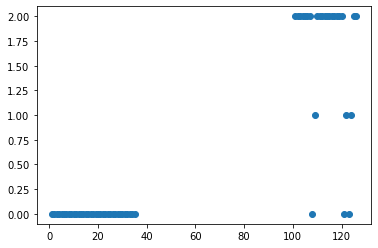

Case =  1
Normal TP =  100.0
Abormal TP =  84.61538461538461
Final ACCURACY = 0.9344262295081968


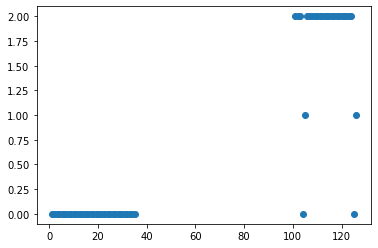

Case =  2
Normal TP =  88.57142857142857
Abormal TP =  76.92307692307693
Final ACCURACY = 0.8360655737704918


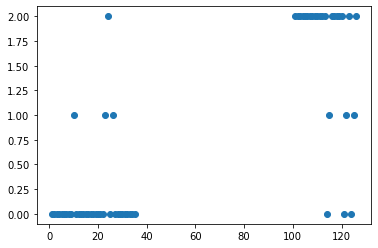

Case =  3
Normal TP =  97.14285714285714
Abormal TP =  50.0
Final ACCURACY = 0.7704918032786885


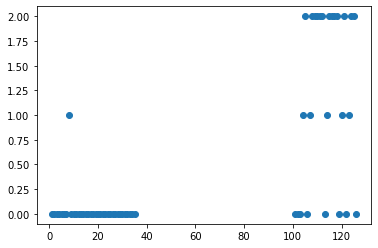

Case =  4
Normal TP =  68.57142857142857
Abormal TP =  73.07692307692307
Final ACCURACY = 0.7049180327868853


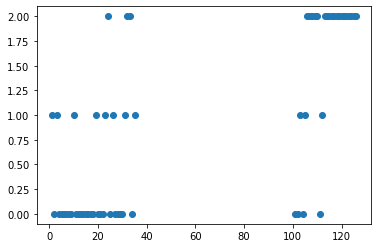

Case =  5
Normal TP =  100.0
Abormal TP =  92.3076923076923
Final ACCURACY = 0.9672131147540983


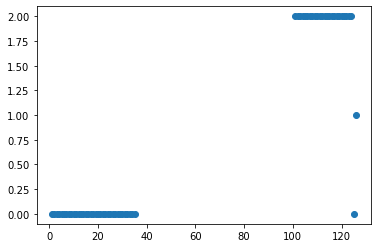

Case =  6
Normal TP =  94.28571428571428
Abormal TP =  84.61538461538461
Final ACCURACY = 0.9016393442622951


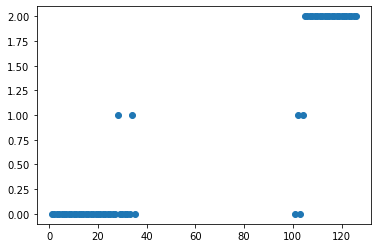

Case =  7
Normal TP =  77.14285714285715
Abormal TP =  92.3076923076923
Final ACCURACY = 0.8360655737704918


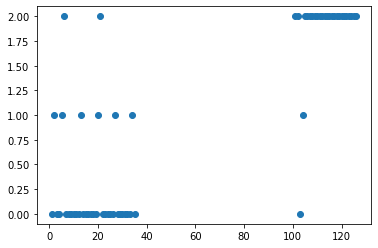

Case =  8
Normal TP =  100.0
Abormal TP =  69.23076923076923
Final ACCURACY = 0.8688524590163934


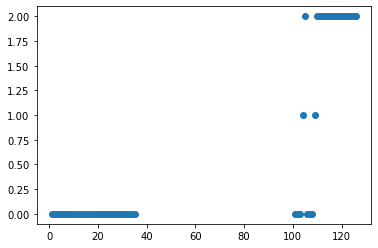

Case =  9
Normal TP =  100.0
Abormal TP =  92.3076923076923
Final ACCURACY = 0.9672131147540983


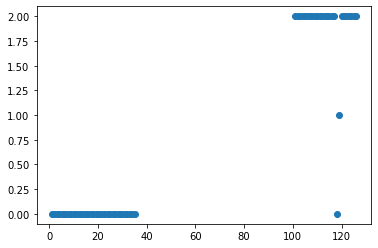

Case =  10
Normal TP =  100.0
Abormal TP =  100.0
Final ACCURACY = 1.0


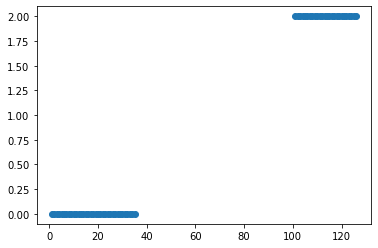

Case =  11
Normal TP =  85.71428571428571
Abormal TP =  84.61538461538461
Final ACCURACY = 0.8524590163934426


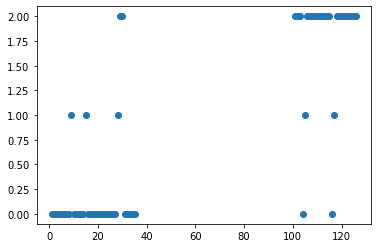

Case =  12
Normal TP =  94.28571428571428
Abormal TP =  65.38461538461539
Final ACCURACY = 0.819672131147541


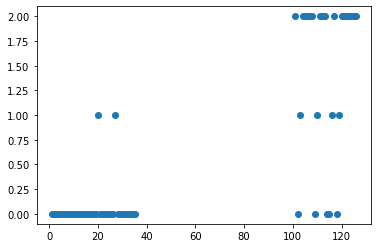

Case =  13
Normal TP =  94.28571428571428
Abormal TP =  92.3076923076923
Final ACCURACY = 0.9344262295081968


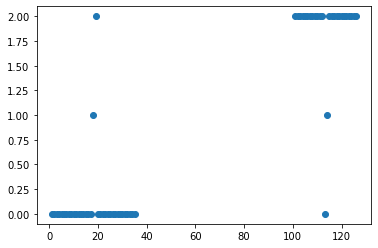

Case =  14
Normal TP =  94.28571428571428
Abormal TP =  30.76923076923077
Final ACCURACY = 0.6721311475409836


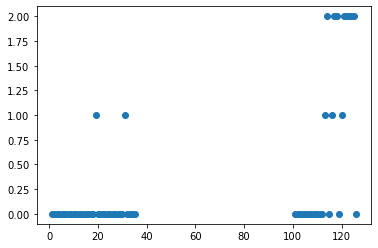

Case =  15
Normal TP =  68.57142857142857
Abormal TP =  80.76923076923077
Final ACCURACY = 0.7377049180327869


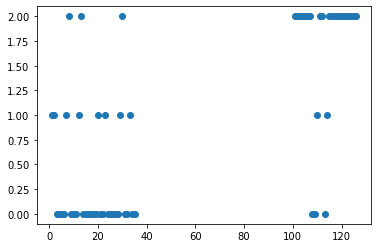

Case =  16
Normal TP =  82.85714285714286
Abormal TP =  84.61538461538461
Final ACCURACY = 0.8360655737704918


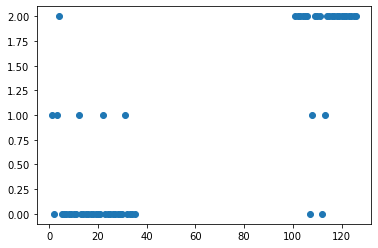

Case =  17
Normal TP =  5.714285714285714
Abormal TP =  92.3076923076923
Final ACCURACY = 0.4262295081967213


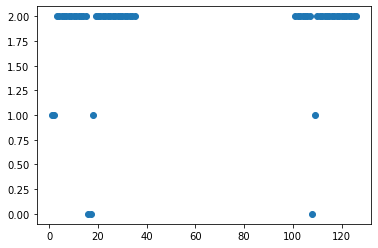

Case =  18
Normal TP =  97.14285714285714
Abormal TP =  42.30769230769231
Final ACCURACY = 0.7377049180327869


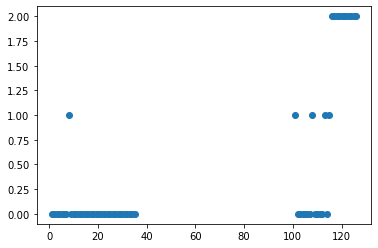

Case =  19
Normal TP =  88.57142857142857
Abormal TP =  34.61538461538461
Final ACCURACY = 0.6557377049180327


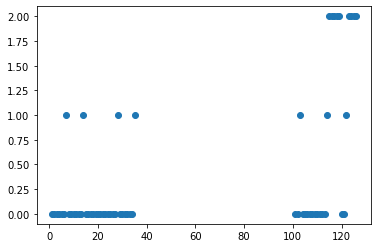

Case =  20
Normal TP =  94.28571428571428
Abormal TP =  65.38461538461539
Final ACCURACY = 0.819672131147541


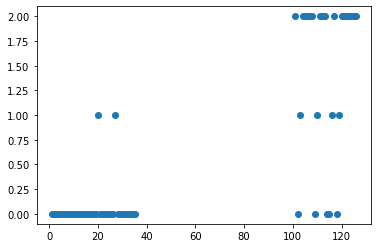

Normal day accuracy = 87.21088435374149
Abormal day accuracy = 74.54212454212454
Total  accuracy = 81.81108508977361


In [18]:
cases_list = []

xpoints= under_sampled_days
NT=5
normal_avg=0
AT=5
abnormal_avg=0

total_avg=0
count=0

for case_i in range(number_of_cases): 
    print("Case = ",case_i)
    ypoints = copy.deepcopy(cases_pred_case_i[case_i])
    # print("init y = ",ypoints)

    ypoints = getAnamoly(ypoints)
    error_vals = cases_pred_error_case_i[case_i]
    # print("prcoessed y = ",ypoints)
    
    normal_tp=0
    normal_preds = ypoints[:35]
    for pred in normal_preds:
        if pred==0:
            normal_tp+=1
            
    abnormal_tp=0 
    abnormal_preds = ypoints[100:126]
    for pred in abnormal_preds: 
        if pred==2: 
            abnormal_tp+=1
            
    
   
    new_ypoints =  normal_preds + abnormal_preds       
    normal_tp = (normal_tp/35)*100
    abnormal_tp = (abnormal_tp/26)*100
#     if normal_tp>NT and abnormal_tp>AT:
#         count+=1
#         normal_avg += normal_tp
#         abnormal_avg +=abnormal_tp
#         total_avg += (accuracy*100)
    print("Normal TP = ",normal_tp)
    print("Abormal TP = ",abnormal_tp) 
    Y_true=[0]*35 
    Y_true.extend([2]*26)
    Y_pred = new_ypoints
    precision,recall,fscore,support=precision_recall_fscore_support(Y_true, Y_pred, average='micro')
    accuracy=accuracy_score(Y_true,Y_pred)
    print("Final ACCURACY = {}".format(accuracy)) 
        
        
    if normal_tp>=NT and abnormal_tp>=AT:
        count+=1
        normal_avg += normal_tp
        abnormal_avg +=abnormal_tp
        total_avg += (accuracy*100)
        cases_list.append(case_i)
        
    plt.scatter(xpoints, new_ypoints) 
    plt.show()
    

normal_avg = normal_avg/count
abnormal_avg = abnormal_avg/count 
total_avg = total_avg/count 

print("Normal day accuracy = {}".format(normal_avg))
print("Abormal day accuracy = {}".format(abnormal_avg))
print("Total  accuracy = {}".format(total_avg))
